# Multi-Scenario MORDM Overijssel
This Jupyter Notebook uses the model developed by [Ciullo et al. (2019)](https://scholar.google.com/citations?hl=en&user=fDZCVVYAAAAJ&view_op=list_works&sortby=pubdate#d=gs_md_cita-d&u=%2Fcitations%3Fview_op%3Dview_citation%26hl%3Den%26user%3DfDZCVVYAAAAJ%26sortby%3Dpubdate%26citation_for_view%3DfDZCVVYAAAAJ%3AqjMakFHDy7sC%26tzom%3D-120) and the [ema_workbench by Jan Kwakkel](https://github.com/quaquel/EMAworkbench) to evaluate what possible strategies the Overijjsel is likely to use to increase its resilience to flood risk. It is specifically aimed towards finding optimal strategies for the Overijjsel province, namely minimizing casualties and damages across the model runtime in dike rings 4-5 and minimizing dike investment costs for all dike rings. By performing this analysis, Gelderland gains strategic information on which strategies the downstream province is likely to follow, if they choose to only take into account their own objectives. 

## Imports

In [45]:
# Standard Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import networkx as nx
import scipy as sp
import plotly.express as px


# Workbench Imports
from ema_workbench import (Model, MultiprocessingEvaluator, ScalarOutcome, RealParameter, IntegerParameter, CategoricalParameter, optimize, Scenario, Constant, ema_logging,perform_experiments, SequentialEvaluator, Policy)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS, SequentialEvaluator, BaseEvaluator
from ema_workbench.analysis import parcoords, prim


ema_logging.log_to_stderr(ema_logging.INFO)


<Logger EMA (DEBUG)>

## General Model Setup
Here, we specify the numbers for the experiment and optimization runs to perform as well as other parameters used in this notebook

In [46]:
# Number of nfes for the Model
n_nfe = 20000

#Number of scenarios for the deep uncertainty evaluation of promising scenarios
n_scenarios = 1000

#Path to the reference scenarios to use for MORDM
path_noaction = "../results/10000Scenarios_NoAction_PF1.tar.gz"

#Specify province
province = "Overijssel"

## Model Specification
Problem Formulation 7, specified in the problem_formulation.py file is calles to initiate the dike model from Overijssels framing. 


In [47]:
# Model Imports
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation

dike_model, planning_steps = get_model_for_problem_formulation(7)
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)

## Specify reference scenario
Firstly, we load the results from the open exploration with no action taken to select a reference scenario that shows the most expected number of deaths. This, so-to-say worst-case scenario is then used to find the optimal policies using the MORDM approach.  

In [11]:
experiments, outcomes = load_results(path_noaction)

[MainProcess/INFO] results loaded succesfully from /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/10000Scenarios_NoAction_PF1.tar.gz


In [19]:
outcomes_df = pd.DataFrame(outcomes)

#Get index of worst scenario
index_wc = outcomes_df.sort_values("Expected Number of Deaths").tail(5).index
experiment_wc = experiments.iloc[index_wc]
reference_scenarios = [Scenario(f"{index}", **row) for index, row in experiment_wc.iloc[0:,0:19].iterrows()]

## Run Optimization on Worst Case Reference Scenario
Due to limited computational resources, we ran 20000 function evaluations in the epsilon-NSGA II multi-objective evolutionary algorithm (MOEA) implemented in the ema_workbench. As a convergence metric, the epsilon progress was used. 

In [6]:
ema_logging.log_to_stderr(ema_logging.INFO)

convergence_metrics = [EpsilonProgress()]

with MultiprocessingEvaluator(dike_model) as evaluator:
    results_epsilon_0_1 = evaluator.optimize(nfe=n_nfe, epsilons=[0.01,]*len(dike_model.outcomes), 
    reference = reference_scenarios[0], convergence= convergence_metrics, searchover="levers")

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 498/10000 nfe
[MainProcess/INFO] generation 10: 995/10000 nfe
[MainProcess/INFO] generation 15: 1493/10000 nfe
[MainProcess/INFO] generation 20: 1993/10000 nfe
[MainProcess/INFO] generation 25: 2493/10000 nfe
[MainProcess/INFO] generation 30: 2988/10000 nfe
[MainProcess/INFO] generation 35: 3474/10000 nfe
[MainProcess/INFO] generation 40: 3911/10000 nfe
[MainProcess/INFO] generation 45: 4248/10000 nfe
[MainProcess/INFO] generation 50: 4576/10000 nfe
[MainProcess/INFO] generation 55: 4898/10000 nfe
[MainProcess/INFO] generation 60: 5201/10000 nfe
[MainProcess/INFO] generation 65: 5519/10000 nfe
[MainProcess/INFO] generation 70: 5838/10000 nfe
[MainProcess/INFO] generation 75: 6156/10000 nfe
[MainProcess/INFO] generation 80: 6476/10000 nfe
[MainProcess/INFO] generation 85: 6780/10000 nfe
[MainProcess/INFO] generation 90: 7085/10000 nfe
[MainProcess/INFO] generation 95: 7397/10000

In [7]:
results, convergence = results_epsilon_0_1

In [8]:
# Save Results
save_results(results_epsilon_0_1, "../results/"+str(n_nfe)+"nfe_BaseCaseMORDM_Overijjsel.tar.gz")

[MainProcess/INFO] results saved successfully to /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/10000nfe_BaseCaseMORDM_Overijjsel.tar.gz


In [25]:
# Load Results
results_epsilon_0_1 = load_results("../results/"+str(n_nfe)+"nfe_BaseCaseMORDM_Overijjsel.tar.gz")

[MainProcess/INFO] results loaded succesfully from /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/20000nfe_BaseCaseMORDM_Overijjsel.tar.gz


### Check for Convergence
The optimization algorithm is now checked for convergence based on the Epsilon progress 

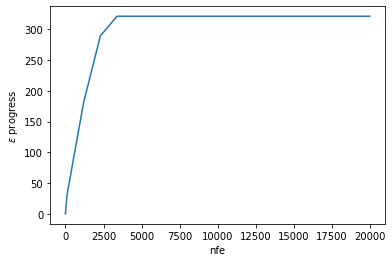

In [26]:
results, convergence = results_epsilon_0_1
convergence = pd.DataFrame(convergence)
plt.plot(convergence.nfe, convergence.epsilon_progress)
plt.ylabel('$\epsilon$ progress')
plt.xlabel('nfe')
plt.show()

## Resulting optimal policies
The algorithm found a single solution, which is the most optimal for the reference, worst-case case scenario. The algorithm converges after around 3800 nfes, and there is a single policy pareto dominant to all other possible solutions: The do-nothing alternatives. This implicates that for the selected worst case scenario, it is optimal for the Overijssel province to not take any action. This is an important insight, as it shows that when thinking about the worst-case scenario in terms of deaths, it is Gelderland that has to take action. However, it shows another important aspect to consider when confronted with deep uncertainty: The necessaty to assess this specific policy resulting from MORDM under deep uncertainty for the Overijssel province and then run multiple optimizations based on differently selected reference case scenarios

In [27]:
results

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A4 Expected Annual Damage,A5 Expected Annual Damage,A4 Expected Number of Deaths,A5 Expected Number of Deaths,A1_5 Dike Investment Costs,Room for River Investment Costs,Evacuation Costs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Re-Evaluate under deep uncertainty
We now re-evaluate the single-outcome under deep uncertainty for the Overijssel province.

In [30]:
policies = results.iloc[:,0:31]
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [31]:
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies_to_evaluate)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [32]:
#Save results
save_results(results, "../results/DeepUncertainty1policy_1000scenarios_Overijjsel.tar.gz")

[MainProcess/INFO] results saved successfully to /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/DeepUncertainty1policy_1000scenarios_Overijjsel.tar.gz


### Signal-to-noise Ratio
To assess the robustness of the do-nothing policy for Overijssel, we calculate the signal-to-noise ratio.

In [7]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [8]:
experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in dike_model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A1_5 Dike Investment Costs,A4 Expected Annual Damage,A4 Expected Number of Deaths,A5 Expected Annual Damage,A5 Expected Number of Deaths,Evacuation Costs,Room for River Investment Costs
0,0.0,5.840764e+14,0.000118,1.046700e+16,0.008415,0.0,0.0


### Maximum Regret
As the maximum regret measure compares different policies against each other, it is not feasible to calculate when only one single optimal policy is assessed

In [49]:
#Load results
results = load_results("../results/DeepUncertainty8policies_1000scenarios_Overijjsel.tar.gz")

[MainProcess/INFO] results loaded succesfully from /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/DeepUncertainty8policies_1000scenarios_Overijjsel.tar.gz


## Scenario Discovery
We perform Scenario Discovery using the PRIM-algorithm to discover such scenarios in which the robust policies fail. We focus on such scenarios where death and damages occur.

In [50]:
experiments, outcomes = results
x = experiments.iloc[:,0:19]

outcomes["selection"] = outcomes["A4 Expected Annual Damage"] + outcomes["A5 Expected Annual Damage"] + outcomes["A4 Expected Number of Deaths"] + outcomes["A5 Expected Number of Deaths"]

y =  outcomes["selection"] > 0 
prim_alg = prim.Prim(x,y, threshold=0.5)
box = prim_alg.find_box()

[MainProcess/INFO] 1000 points remaining, containing 519 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.141, coverage: 0.27167630057803466, density: 1.0 restricted_dimensions: 6


In [33]:
box.inspect_tradeoff()


alt.VConcatChart(...)

We select box 17, as it shows a good mixture between coverage and density

In [51]:
n_box = 17
box.inspect(n_box)


coverage    0.645472
density     0.811138
id                17
mass           0.413
mean        0.811138
res_dim            4
Name: 17, dtype: object

              box 17                                           
                 min         max                      qp values
A.4_pfail   0.000904    0.661754  [-1.0, 2.714413313129453e-09]
A.1_Bmax   30.091208  333.849175    [-1.0, 0.14822985850514236]
A.3_pfail   0.191052    0.999145  [4.989930418277363e-07, -1.0]
A.2_pfail   0.177260    0.999657  [4.705781716242567e-05, -1.0]



In [52]:
box.select(n_box)
scens_in_box = experiments.iloc[box.yi]
outcomes_in_box = {k:v[box.yi] for k,v in outcomes.items()}
#Save results
save_results((scens_in_box, outcomes_in_box), '../results/mordm_'+str(n_box)+'_Overijjsel.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/mordm_17_Overijjsel.tar.gz


# Multi-Scenario MORDM
Based on the results of scenario discovery, we now continue to select three of such scenarios based on the worst outcomes in terms of casualties, damages and total costs. We will take each of these scenarios as a reference scenario to run an optimization algorithm for the levers to choose. 

In [53]:
#Load results
# mordm_results = load_results('../results/mordm_29_Gelderland.tar.gz')
results_df = pd.concat([pd.DataFrame(scens_in_box).reset_index(drop=True), pd.DataFrame(outcomes_in_box)], axis = 1)

In [44]:
results_df.describe()

,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.2_Bmax,A.2_pfail,A.3_Bmax,A.3_pfail,A.4_Bmax,A.4_pfail,A.5_Bmax,...,A4 Expected Annual Damage,A5 Expected Annual Damage,A4 Expected Number of Deaths,A5 Expected Number of Deaths,A1_5 Dike Investment Costs,Room for River Investment Costs,Evacuation Costs,selection,Deaths Aggregated,Damages Aggregated
count,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,...,4.130000e+02,4.130000e+02,413.000000,413.000000,413.0,413.0,413.0,4.130000e+02,413.000000,4.130000e+02
mean,67.694915,176.579386,0.519425,194.061733,0.593366,192.648177,0.599484,190.527042,0.321817,187.951985,...,3.696344e+07,7.901835e+07,0.016946,0.070193,0.0,0.0,0.0,1.159818e+08,0.087139,1.159818e+08
std,38.087201,89.400195,0.288205,92.250658,0.235636,90.731763,0.234562,94.916699,0.190981,90.831935,...,4.249546e+07,1.848046e+08,0.019031,0.160197,0.0,0.0,0.0,1.877957e+08,0.160263,1.877957e+08
min,0.000000,30.557857,0.002344,30.840209,0.177747,30.250076,0.191974,30.921558,0.000904,30.245978,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000e+00
25%,34.000000,96.370595,0.278657,120.299375,0.388304,116.357122,0.392729,105.551648,0.161617,109.861883,...,2.769952e+05,0.000000e+00,0.000139,0.000000,0.0,0.0,0.0,3.439878e+06,0.001373,3.439878e+06
50%,67.000000,175.536200,0.526302,191.395201,0.595400,195.969431,0.602764,197.271662,0.315498,188.191975,...,1.556786e+07,0.000000e+00,0.007286,0.000000,0.0,0.0,0.0,5.160957e+07,0.025344,5.160957e+07
75%,102.000000,255.256522,0.774826,273.184049,0.798443,269.397795,0.802107,275.991716,0.486101,262.937689,...,6.572651e+07,2.027581e+07,0.032175,0.020692,0.0,0.0,0.0,1.197545e+08,0.058058,1.197545e+08
max,132.000000,333.434563,0.998736,349.500908,0.997327,349.496223,0.997448,347.837704,0.661379,349.698636,...,1.571962e+08,9.262290e+08,0.061578,0.803309,0.0,0.0,0.0,9.438639e+08,0.815868,9.438639e+08


In [40]:
#Sum up Deaths and Damages
results_df["Deaths Aggregated"] = results_df["A4 Expected Number of Deaths"] + results_df["A5 Expected Number of Deaths"]
results_df["Damages Aggregated"] = results_df["A4 Expected Annual Damage"] + results_df["A5 Expected Annual Damage"]

In [41]:
#Get the three reference scenarios
scenario_indices = [results_df.sort_values(["Evacuation Costs"]).tail(1).index[0], 
                    results_df.sort_values(["Deaths Aggregated"]).tail(1).index[0], 
                    results_df.sort_values(["Damages Aggregated"]).tail(1).index[0]]
selected = results_df.iloc[scenario_indices, 0:19]

In [19]:
#Create the three reference case scenario instances
scenarios_mordm = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

## Optimization run 2, now for 3 reference case scenarios
We now search for optimal policies utilizing the three new refence scenarios specified above. For reasons already mentioned, we again use 20000 nfes and the epsilon progress to check for convergence

In [20]:
def optimize(scenario, nfe, model, converge_metrics, epsilons):

    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                     convergence=convergence_metrics,
                                     epsilons=epsilons,
                                     reference=scenario)
    return results, convergence


results = []
i = 0

for scenario in scenarios_mordm:
    convergence_metrics = [EpsilonProgress()]
    epsilons = [0.1,]*len(dike_model.outcomes)
    
    results.append(optimize(scenario, n_nfe, dike_model, convergence_metrics, epsilons))

    #Save results in between
    save_results(results[i], "../results/ms_mordm_"+str(n_nfe)+"nfe_"+province+"_reference"+str(i)+".tar.gz")
    i = i+1


[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/20000 nfe
[MainProcess/INFO] generation 5: 500/20000 nfe
[MainProcess/INFO] generation 10: 998/20000 nfe
[MainProcess/INFO] generation 15: 1497/20000 nfe
[MainProcess/INFO] generation 20: 1997/20000 nfe
[MainProcess/INFO] generation 25: 2494/20000 nfe
[MainProcess/INFO] generation 30: 2991/20000 nfe
[MainProcess/INFO] generation 35: 3486/20000 nfe
[MainProcess/INFO] generation 40: 3978/20000 nfe
[MainProcess/INFO] generation 45: 4472/20000 nfe
[MainProcess/INFO] generation 50: 4954/20000 nfe
[MainProcess/INFO] generation 55: 5443/20000 nfe
[MainProcess/INFO] generation 60: 5933/20000 nfe
[MainProcess/INFO] generation 65: 6429/20000 nfe
[MainProcess/INFO] generation 70: 6922/20000 nfe
[MainProcess/INFO] generation 75: 7413/20000 nfe
[MainProcess/INFO] generation 80: 7905/20000 nfe
[MainProcess/INFO] generation 85: 8397/20000 nfe
[MainProcess/INFO] generation 90: 8895/20000 nfe
[MainProcess/INFO] generation 95: 9393/20000

In [4]:
#Load results
results = []
results.append(load_results("../results/ms_mordm_20000nfe_"+province+"_reference0.tar.gz"))
results.append(load_results("../results/ms_mordm_20000nfe_"+province+"_reference1.tar.gz"))
results.append(load_results("../results/ms_mordm_20000nfe_"+province+"_reference2.tar.gz"))

[MainProcess/INFO] results loaded succesfully from /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/ms_mordm_20000nfe_Overijssel_reference0.tar.gz
[MainProcess/INFO] results loaded succesfully from /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/ms_mordm_20000nfe_Overijssel_reference1.tar.gz
[MainProcess/INFO] results loaded succesfully from /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/ms_mordm_20000nfe_Overijssel_reference2.tar.gz


## Check for Convergence

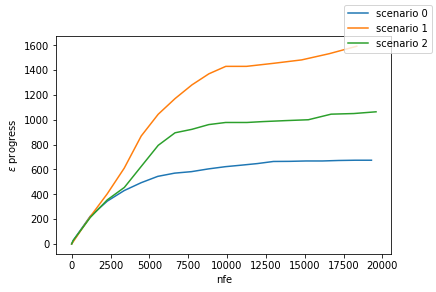

In [6]:
fig, (ax2) = plt.subplots(ncols=1)
for i, (_, convergence) in enumerate(results):
    ax2.plot(convergence["nfe"], convergence["epsilon_progress"], label=f'scenario {i}')

ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')
fig.legend()
plt.show()

Scenarios 0 and 2 converge relatively fast. Scenario 1 is however not fully converged based on the epsilon progress convergence metric. Having more computational resources, further function evaluations should be performed.

In [7]:
ms_results_df = pd.concat([results[0][0],results[1][0], results[2][0]], axis=0)
ms_results_df = ms_results_df.reset_index(drop=True)

## Display results in a parallell coordinated plot

In [8]:
fig = px.parallel_coordinates(ms_results_df, labels= {"A4 Expected Annual Damage" : "A4 Damage", "A5 Expected Annual Damage" : "A5 Damage", "A4 Expected Number of Deaths" : "A4 Casualties", "A5 Expected Number of Deaths" : "A5 Casualties", "A1_5 Dike Investment Costs" : "Investment Costs", "Room for River Investment Costs" : "RfR Investment Costs"}, color = ms_results_df.index, dimensions= ["A4 Expected Annual Damage", "A5 Expected Annual Damage", "A4 Expected Number of Deaths","A5 Expected Number of Deaths", "A1_5 Dike Investment Costs", "Room for River Investment Costs"])
fig.show()

We further create a more aggregated version of the parallell coordinates plot to better see the tradeoffs involved in the different policies.

In [10]:
ms_results_agg = ms_results_df.iloc[:, 31::]
ms_results_agg["Expected Casualties"] = ms_results_agg["A4 Expected Number of Deaths"] + ms_results_agg["A5 Expected Number of Deaths"]
ms_results_agg["Expected Damage"] = ms_results_agg["A4 Expected Annual Damage"] + ms_results_agg["A5 Expected Annual Damage"]
ms_results_agg["Traditional Costs"] = ms_results_agg["A1_5 Dike Investment Costs"] + ms_results_agg["Evacuation Costs"]

In [11]:
fig = px.parallel_coordinates(ms_results_agg, dimensions=["Expected Casualties","Expected Damage", "Traditional Costs", "Room for River Investment Costs"], color = ms_results_agg.index)
fig.update_layout(showlegend=False)
fig.show()

## Selection of promising policies
We select from the solutions found only these which lead to no expected deaths, no expected damage and no evacuation costs. From these selection onwards, due to comparability with the other notebooks and computational resources, we select the 10 policies with lowest total costs (Dike investment costs and Room for River costs combined)

In [12]:
ms_results_subset = ms_results_df[
    ((ms_results_df["A4 Expected Number of Deaths"] + ms_results_df["A5 Expected Number of Deaths"]) == 0) &
    ((ms_results_df["A4 Expected Annual Damage"] + ms_results_df["A5 Expected Annual Damage"]) == 0) &
    ((ms_results_df["Evacuation Costs"]) == 0) ]

ms_results_subset["Total Costs"] = ms_results_subset["A1_5 Dike Investment Costs"] + ms_results_subset["Room for River Investment Costs"] 

In [15]:
#Select only the 10 cheapest policies in terms of total costs. 
ms_results_subset = ms_results_subset.sort_values("Total Costs").head(10)

In [16]:
ms_policies = ms_results_subset.iloc[:,0:31]
ms_policies_to_evaluate = []

for i, policy in ms_policies.iterrows():
    ms_policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [17]:
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, ms_policies_to_evaluate)

#Save results
save_results(results, "../results/Multi_Scenario_DeepUncertainty"+str(len(ms_policies_to_evaluate))+"policies_"+str(n_scenarios)+"scenarios_"+province+".tar.gz")

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/Multi_Scenario_DeepUncertainty10policies_1000scenarios_Overijssel.tar.gz


In [4]:
#Load results
reevaluation_results = load_results("../results/Multi_Scenario_DeepUncertainty10policies_1000scenarios_Overijssel.tar.gz")

[MainProcess/INFO] results loaded succesfully from /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/Multi_Scenario_DeepUncertainty10policies_1000scenarios_Overijssel.tar.gz


## Robustness assessment
### Domain criterion

In [5]:
experiments, outcomes = reevaluation_results
reevaluation_df = pd.concat([pd.DataFrame(experiments), pd.DataFrame(outcomes)], axis = 1)

domain_criterion = pd.DataFrame(columns=["policy", "A4 Damage", "A5 Damage", "A4 Deaths", "A5 Deaths", "Evacuation Costs"])

for policy in reevaluation_df["policy"].unique():
    policy_subset = reevaluation_df[reevaluation_df["policy"] == policy]

    a12_damage_dc = len(policy_subset["A4 Expected Annual Damage"][policy_subset["A4 Expected Annual Damage"] > 0])/1000
    a3_damage_dc = len(policy_subset["A5 Expected Annual Damage"][policy_subset["A5 Expected Annual Damage"] > 0])/1000
    a12_deaths_dc = len(policy_subset["A4 Expected Number of Deaths"][policy_subset["A4 Expected Number of Deaths"] > 0])/1000
    a3_deaths_dc = len(policy_subset["A5 Expected Number of Deaths"][policy_subset["A5 Expected Number of Deaths"] > 0])/1000
    evac_costs = len(policy_subset["Evacuation Costs"][policy_subset["Evacuation Costs"] > 0])/1000

    domain_criterion = domain_criterion.append(pd.DataFrame({"policy": [policy],"A4 Damage": [a12_damage_dc], "A5 Damage" : [a3_damage_dc], "A4 Deaths" : [a12_deaths_dc], "A5 Deaths" : [a3_deaths_dc], "Evacuation Costs" : [evac_costs]}) )

domain_criterion = domain_criterion.reset_index(drop=True)

In [6]:
domain_criterion

,policy,A4 Damage,A5 Damage,A4 Deaths,A5 Deaths,Evacuation Costs
0,5,0.059,0.297,0.059,0.297,0.0
1,7,0.080,0.198,0.080,0.198,0.0
2,592,0.248,0.019,0.248,0.019,0.0
3,168,0.105,0.003,0.105,0.003,0.0
4,21,0.109,0.128,0.109,0.128,0.0
5,660,0.217,0.043,0.217,0.043,0.0
6,564,0.080,0.002,0.080,0.002,0.0
7,653,0.273,0.041,0.273,0.041,0.0
8,609,0.236,0.043,0.236,0.043,0.0
9,16,0.116,0.080,0.116,0.080,0.0


As we can see, all policies have no evacuation costs in all the deep uncertainty runs. This is why we focus on the trade-offs in damages and deaths. The domain criterion being a dimensionless metric, we also add the total costs (Room for River costs plus Dike investment costs) in the parallel coordinated plot to show the "price of robustness". It is important to keep in mind that unlinke the domain criterion metrics, the total cost unit is monetary.

In [7]:
policy_costs = reevaluation_df.groupby("policy").mean()
policy_costs["Total Costs"] = policy_costs["A1_5 Dike Investment Costs"] +  policy_costs["Room for River Investment Costs"]
domain_criterion_costs = pd.merge(domain_criterion, policy_costs[["Total Costs"]], how="left", on="policy")


In [9]:
domain_criterion_costs

,policy,A4 Damage,A5 Damage,A4 Deaths,A5 Deaths,Evacuation Costs,Total Costs
0,5,0.059,0.297,0.059,0.297,0.0,4.847598e+07
1,7,0.080,0.198,0.080,0.198,0.0,1.634670e+08
2,592,0.248,0.019,0.248,0.019,0.0,2.149874e+08
3,168,0.105,0.003,0.105,0.003,0.0,2.632346e+08
4,21,0.109,0.128,0.109,0.128,0.0,2.790604e+08
5,660,0.217,0.043,0.217,0.043,0.0,3.045616e+08
6,564,0.080,0.002,0.080,0.002,0.0,3.648354e+08
7,653,0.273,0.041,0.273,0.041,0.0,3.802911e+08
8,609,0.236,0.043,0.236,0.043,0.0,4.887861e+08
9,16,0.116,0.080,0.116,0.080,0.0,6.513040e+08


In [10]:
fig = px.parallel_coordinates(domain_criterion_costs, color = "policy", dimensions=["A4 Damage", "A5 Damage", "A4 Deaths", "A5 Deaths", "Total Costs"])
fig.show()

As the results show, policy 168 and 564 shows very promising results in terms of robustness. When it comes to cost, it can be seen that robustness comes along with a higher cost. Let us look at these policies more closely: 

In [25]:
reevaluation_df[(reevaluation_df["policy"] == 564)].iloc[0, 19:50]

0_RfR 0               0
0_RfR 1               0
0_RfR 2               0
1_RfR 0               0
1_RfR 1               0
1_RfR 2               0
2_RfR 0               0
2_RfR 1               0
2_RfR 2               0
3_RfR 0               0
3_RfR 1               1
3_RfR 2               0
4_RfR 0               0
4_RfR 1               0
4_RfR 2               0
EWS_DaysToThreat      0
A.1_DikeIncrease 0    0
A.1_DikeIncrease 1    0
A.1_DikeIncrease 2    0
A.2_DikeIncrease 0    0
A.2_DikeIncrease 1    0
A.2_DikeIncrease 2    0
A.3_DikeIncrease 0    0
A.3_DikeIncrease 1    0
A.3_DikeIncrease 2    0
A.4_DikeIncrease 0    3
A.4_DikeIncrease 1    0
A.4_DikeIncrease 2    0
A.5_DikeIncrease 0    6
A.5_DikeIncrease 1    0
A.5_DikeIncrease 2    0
Name: 6000, dtype: object

In [26]:
reevaluation_df[(reevaluation_df["policy"] == 168)].iloc[0, 19:50]

0_RfR 0               0
0_RfR 1               0
0_RfR 2               0
1_RfR 0               0
1_RfR 1               0
1_RfR 2               0
2_RfR 0               0
2_RfR 1               0
2_RfR 2               0
3_RfR 0               0
3_RfR 1               0
3_RfR 2               0
4_RfR 0               0
4_RfR 1               0
4_RfR 2               0
EWS_DaysToThreat      0
A.1_DikeIncrease 0    0
A.1_DikeIncrease 1    0
A.1_DikeIncrease 2    0
A.2_DikeIncrease 0    0
A.2_DikeIncrease 1    0
A.2_DikeIncrease 2    0
A.3_DikeIncrease 0    0
A.3_DikeIncrease 1    0
A.3_DikeIncrease 2    0
A.4_DikeIncrease 0    3
A.4_DikeIncrease 1    0
A.4_DikeIncrease 2    0
A.5_DikeIncrease 0    7
A.5_DikeIncrease 1    0
A.5_DikeIncrease 2    0
Name: 3000, dtype: object

Both policies suggest that hightening the dikes at locations A4 and A5 in time step by 3 and respectively 6 or 7 dm is a sufficient solution for the objectives for Overijssel. To increase robustness, it might be worth considering implementing the third room for river project. 

## Scenario Discovery: PRIM
At the last stage of Multi-Scenario MORDM, we will conduct another scenario dicovery using the PRIM algorithm to specifically show under which scenarios these policies fail. We consider a policy failed when either deaths or damage occurs. 

In [11]:
outcomes["condition"] = outcomes["A4 Expected Annual Damage"] + outcomes["A5 Expected Annual Damage"] + outcomes["A4 Expected Number of Deaths"] + outcomes["A5 Expected Number of Deaths"]
x = experiments.iloc[:,0:19]
y = outcomes["condition"] > 0
prim_alg = prim.Prim(x,y, threshold=0.5)
box = prim_alg.find_box()

[MainProcess/INFO] 10000 points remaining, containing 2227 cases of interest
[MainProcess/INFO] mean: 0.9472727272727273, mass: 0.055, coverage: 0.23394701392007183, density: 0.9472727272727273 restricted_dimensions: 8


In [12]:
box.inspect_tradeoff()

alt.VConcatChart(...)

In [27]:
n_box = 47
box.inspect(n_box)

coverage    0.296363
density     0.814815
id                47
mass           0.081
mean        0.814815
res_dim            7
Name: 47, dtype: object

              box 47                                            
                 min         max                       qp values
A.4_pfail   0.000077    0.191247   [-1.0, 6.24332325562951e-175]
A.2_Bmax   30.223294  301.132348       [-1.0, 0.093607138788091]
A.1_Bmax   30.095356  337.480692     [-1.0, 0.13712278849314213]
A.5_pfail   0.000346    0.935973     [-1.0, 0.15613429486485073]
A.3_Bmax   30.245815  336.473949      [-1.0, 0.3359689320244337]
A.3_pfail   0.218843    0.999780  [1.0041789066732276e-16, -1.0]
A.2_pfail   0.279811    0.999826  [4.4985422895201835e-07, -1.0]

